##ECSE 415 - Assignment 1: Image Filtering and Edge Detection

#Theo Ghanem 260972584

# 3 Image Stitching

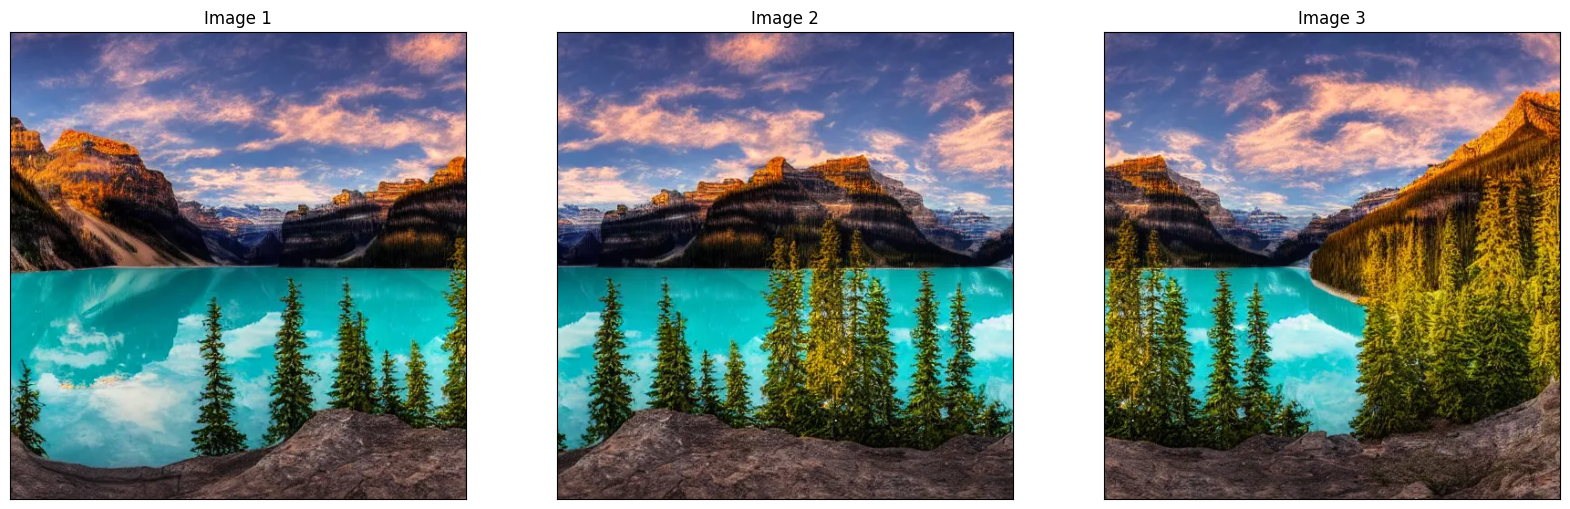

In [71]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

path = '/Users/theog/Documents/CodingProjects/ECSE415_Computer_Vision/Assignments/A2/A2-W24-images/Data/'

#Load the 2 images
image_1 = cv2.imread(path+'Q3/part1.png')
image_2 = cv2.imread(path+'Q3/part2.png')
image_3 = cv2.imread(path+'Q3/part3.png')

image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)
image_3 = cv2.cvtColor(image_3,cv2.COLOR_BGR2RGB)

# display images
plt.figure(figsize=(20, 20))
plt.subplot(131), plt.imshow(image_1)
plt.title('Image 1'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(image_2)
plt.title('Image 2'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(image_3)
plt.title('Image 3'), plt.xticks([]), plt.yticks([])
plt.show()


### (a) Compute the SIFT keypoints and corresponding descriptors for images 1 and 2.


In [72]:
# compute SIFT keypoints for both images
sift = cv2.SIFT_create()
keypoint_1, descriptor_1 = sift.detectAndCompute(image_1,None)
keypoint_2, descriptor_2 = sift.detectAndCompute(image_2,None)

### (b) Find matching keypoints in images 1 and 2 and display the 20 best pairs.

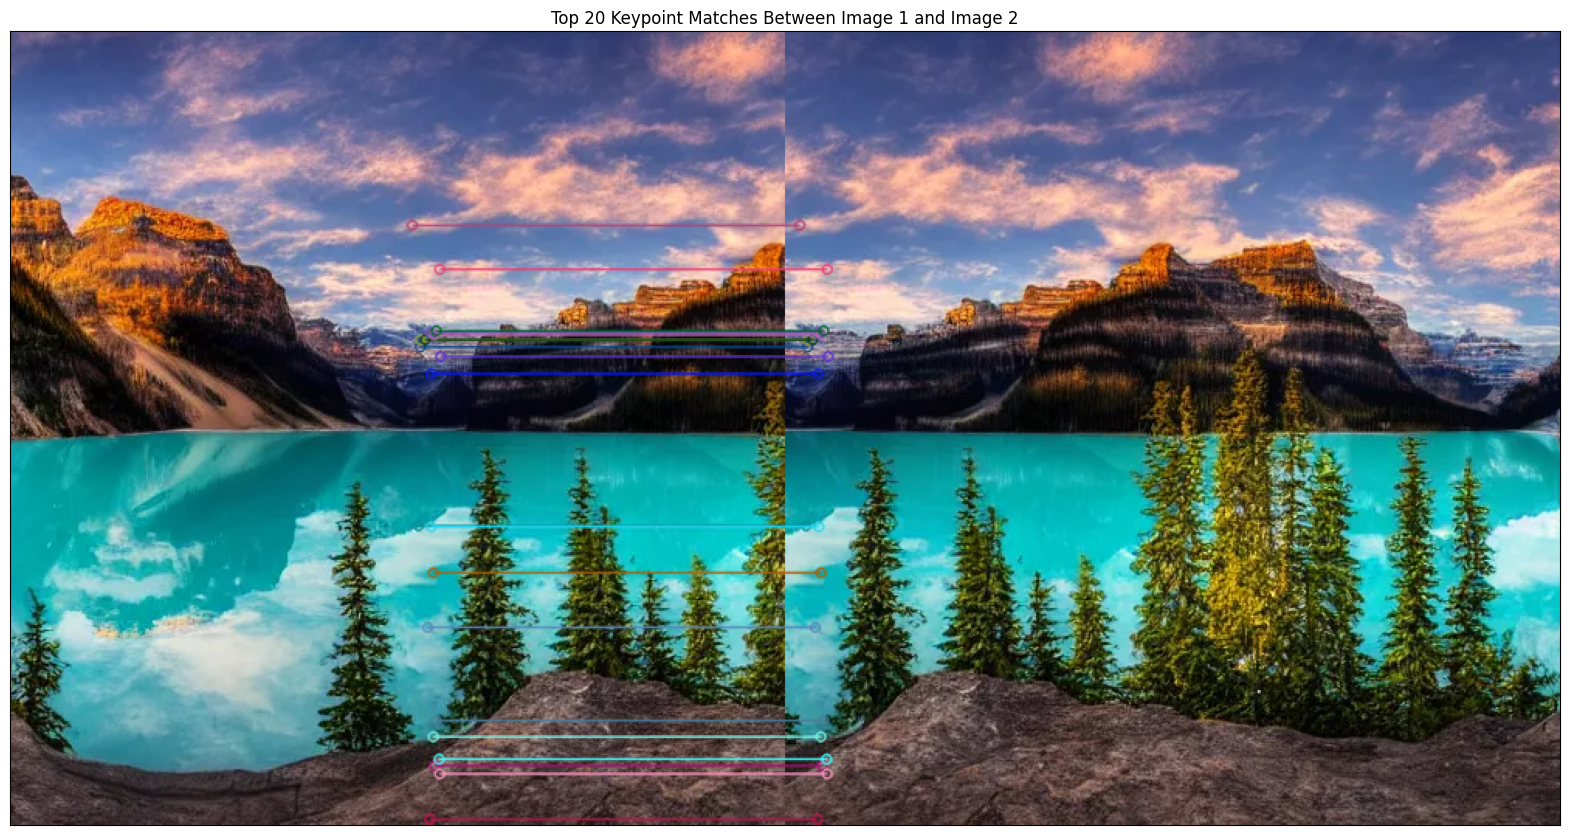

In [73]:
from cv2 import NORM_L2

# match all keypoints between both images using a brute force matcher
bf = cv2.BFMatcher.create(normType = NORM_L2, crossCheck = True)
matches12 = bf.match(descriptor_1,descriptor_2)

# sort matches by distance
matches12 = sorted(matches12, key = lambda x:x.distance)

# display best 20 matches
image_1_and_image_2 = cv2.drawMatches(image_1,keypoint_1,image_2,keypoint_2,matches12[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 20))
plt.imshow(image_1_and_image_2)
plt.title('Top 20 Keypoint Matches Between Image 1 and Image 2'), plt.xticks([]), plt.yticks([])
plt.show()

### (c) Find the homography that best matches the keypoints from image 1 and 2 using the RANSAC method, and apply the resulting transformation to image 1. Image 2 should not be transformed.

In [74]:
#Find the homography that best matches the keypoints from image 1 and 2 using the RANSAC method, and apply the resulting transformation to image 1. Image 2 should not be transformed.

# get the keypoints from the matches (from tutorial 4)
dst_pts = np.float32([ keypoint_1[m.queryIdx].pt for m in matches12 ]).reshape(-1,1,2)
src_pts = np.float32([ keypoint_2[m.trainIdx].pt for m in matches12 ]).reshape(-1,1,2)

# find the homography (from tutorial 4)
homography_12, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

# warp image 1 to image 2 using the homography matrix
image_12 = cv2.warpPerspective(image_1, homography_12, (image_1.shape[1] + image_2.shape[1], image_1.shape[0]))


### (d) Stitch the transformed image 1 and the original image 2 together using linear image blending. Let us call this image 12. Display this image.

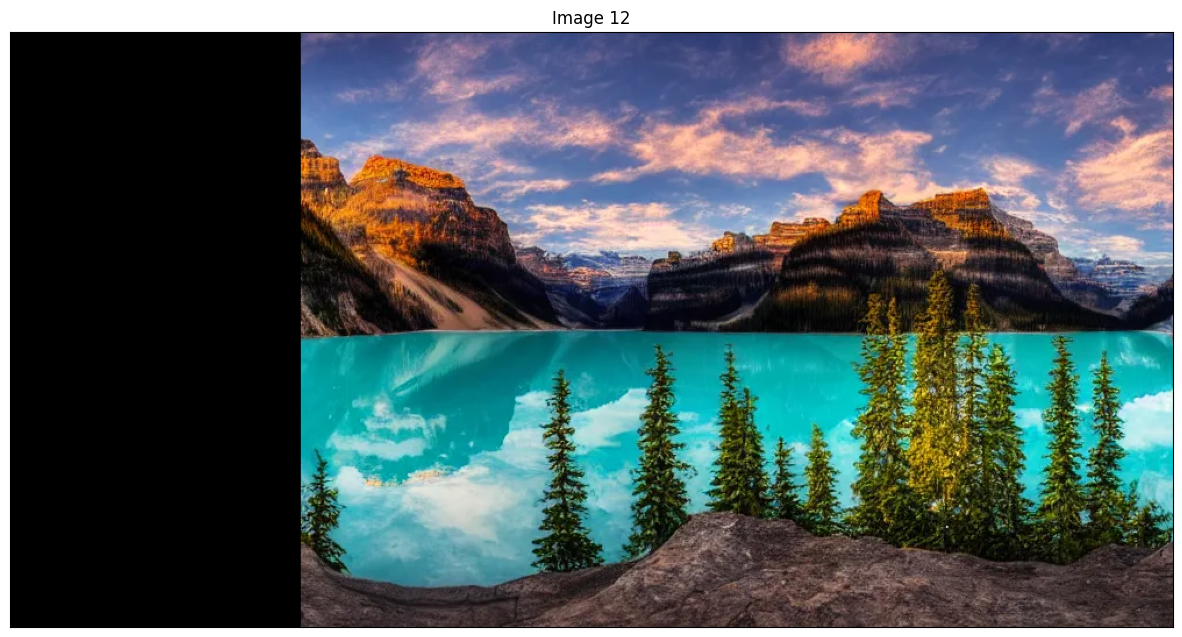

In [75]:

# merge image 2 to image 12 with linear blending
image_12[0:image_2.shape[0], image_2.shape[1]:image_2.shape[1]*2] = image_2

# remove black pixels from left side of image 12
gray_image = cv2.cvtColor(image_12, cv2.COLOR_BGR2GRAY)

# Apply a threshold to identify the black region on the left side
_, thresholded_image = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask with white pixels to keep the non-black region
mask = np.ones_like(image_12, dtype=np.uint8) * 255

# Draw the contours on the mask to fill the black region
for contour in contours:
  x, y, w, h = cv2.boundingRect(contour)
  if x == 0:  # Check if the contour is on the left side (black region)
    mask[y:y+h, x:x+w] = 0

# Use the mask to extract the desired portion of the image
result_image = cv2.bitwise_and(image_12, mask)


# display image 12
plt.figure(figsize=(15, 15))
plt.imshow(result_image)
plt.title('Image 12'), plt.xticks([]), plt.yticks([])
plt.show()

### (e) Compute the SIFT keypoints and corresponding descriptors for images 12 and 3.

In [76]:
# compute SIFT keypoints for image 12
kp12, des12 = sift.detectAndCompute(image_12,None)
kp3, des3 = sift.detectAndCompute(image_3,None)

### (f) Find the matching keypoints in 12 and 3 images and display the 20 best pairs.

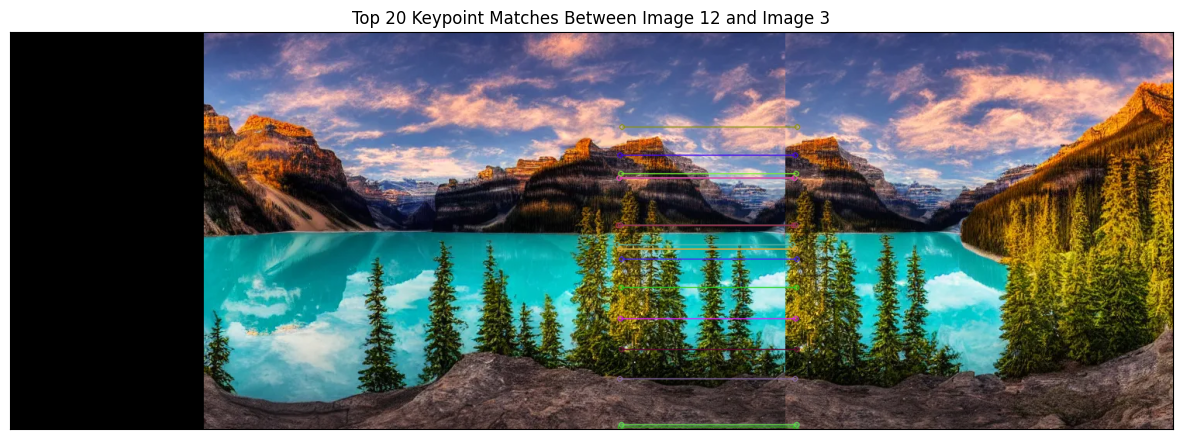

In [77]:
# match all keypoints between image 12 and image 3 using a brute force matcher
bf = cv2.BFMatcher.create(normType = NORM_L2, crossCheck = True)
matches123 = bf.match(des12,des3)

# sort matches by distance
matches123 = sorted(matches123, key = lambda x:x.distance)

# display best 20 matches
image_12_image_3 = cv2.drawMatches(image_12,kp12,image_3,kp3,matches123[:20],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15, 15))
plt.imshow(image_12_image_3)
plt.title('Top 20 Keypoint Matches Between Image 12 and Image 3'), plt.xticks([]), plt.yticks([])
plt.show()


### (g) Compute the homography using the RANSAC method. Apply the transformation to image 3. Image 12 should not be transformed.


In [86]:

# compute homography matrix using RANSAC with the first 20 matches
dst_pts_123 = np.float32([ kp12[m.queryIdx].pt for m in matches123 ]).reshape(-1,1,2)
src_pts_123 = np.float32([ kp3[m.trainIdx].pt for m in matches123 ]).reshape(-1,1,2)

homography_matrix_123, _ = cv2.findHomography(src_pts_123, dst_pts_123, cv2.RANSAC, 5.0)

# warp image 12 to image 3 using the homography matrix
image_123 = cv2.warpPerspective(image_12, homography_matrix_123, (image_12.shape[1] + image_3.shape[1] * 2, image_12.shape[0]))


### (h) Stitch the transformed image 3 and image 12 together using linear image blending. Display the resulting image.


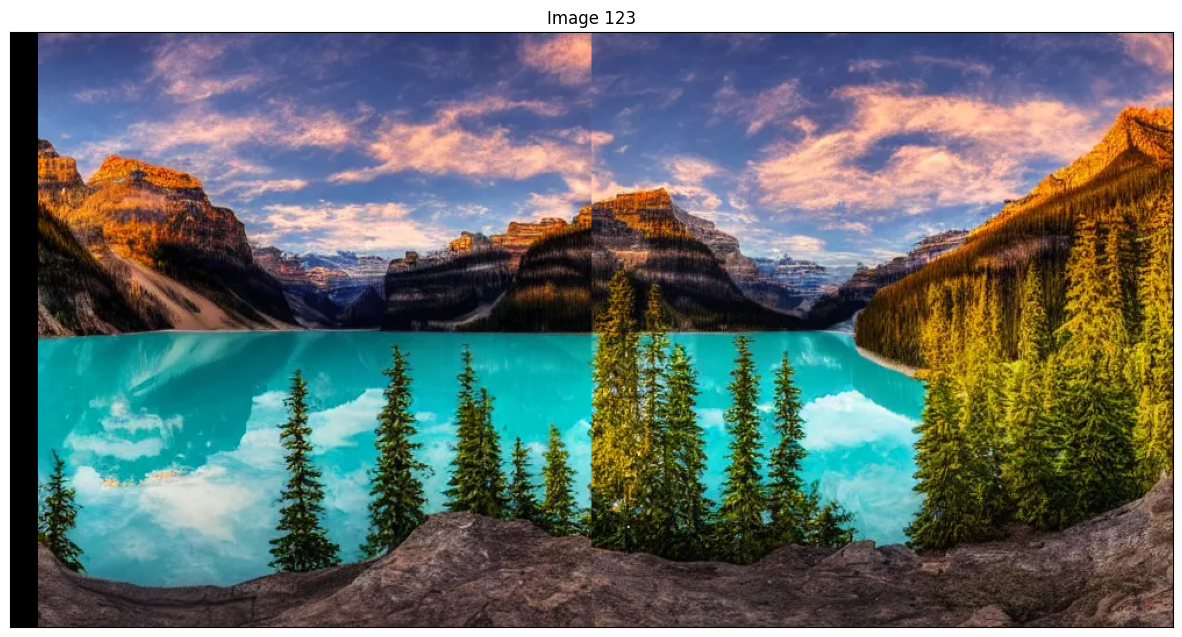

In [87]:
# copy image 3 to the warped image
image_123[0:image_3.shape[0], image_123.shape[1] - image_3.shape[1]:image_123.shape[1]] = image_3

# remove black pixels from left side of image 123
image_123 = image_123[:, int(image_123.shape[1]/2):image_123.shape[1]]

# display warped image
plt.figure(figsize=(15, 15))
plt.imshow(image_123)
plt.title('Image 123'), plt.xticks([]), plt.yticks([])
plt.show()

### (i) Discuss: Note that we could also use multi-band blending in the section (h). When should one prefer pyramid blending over linear blending? 